In [266]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
% matplotlib inline
plt.style.use('ggplot')

In [267]:
df_customer = pd.read_csv('data/customer.csv')

In [268]:
df_customer.columns

Index([u'customerId2', u'churnlabel', u'gender', u'shippingCountry',
       u'dateCreated', u'yearOfBirth', u'premier'],
      dtype='object')

In [269]:
df_receipts = pd.read_csv('data/receipts.csv')

In [270]:
df_receipts.columns

Index([u'customerId2', u'productId', u'divisionId', u'sourceId', u'itemQty',
       u'signalDate', u'receiptId', u'price'],
      dtype='object')

In [271]:
df_returns = pd.read_csv('data/returns.csv')

In [272]:
df_returns.columns

Index([u'customerId2', u'productId', u'divisionId', u'sourceId', u'itemQty',
       u'signalDate', u'receiptId', u'returnId', u'returnAction',
       u'returnReason'],
      dtype='object')

In [273]:
df_sessionsummary = pd.read_csv('data/sessionsummary.csv')

In [274]:
df_sessionsummary.columns

Index([u'customerId2', u'country', u'startTime', u'site', u'pageViewCount',
       u'nonPageViewEventsCount', u'userAgent', u'screenResolution',
       u'browserSize', u'productViewCount', u'productViewsDistinctCount',
       u'productsAddedToBagCount',
       u'productsSavedForLaterFromProductPageCount',
       u'productsSavedForLaterFromCategoryPageCount',
       u'productsPurchasedDistinctCount', u'productsPurchasedTotalCount'],
      dtype='object')

# Customer data exploration

In [275]:
df_customer.shape

(470169, 7)

In [276]:
df_customer.head()

,customerId2,churnlabel,gender,shippingCountry,dateCreated,yearOfBirth,premier
0,1852043,2,F,UK,2005-03-02T19:35:50.000Z,1986,0
1,1825138,1,F,UK,2005-11-25T20:32:39.000Z,1981,0
2,863960,1,M,UK,2005-05-12T13:04:19.000Z,1983,0
3,585725,1,F,UK,2006-03-23T16:59:31.000Z,1976,6
4,1773666,2,F,UK,2006-04-20T18:42:44.000Z,1990,0


In [277]:
for k in df_customer.keys():
    print(k, df_customer[k].nunique(), df_customer[k].isnull().sum())

('customerId2', 470169, 0)
('churnlabel', 2, 0)
('gender', 2, 0)
('shippingCountry', 190, 11)
('dateCreated', 470109, 0)
('yearOfBirth', 125, 0)
('premier', 7, 0)


In [278]:
df_customer['Age'] = 2017-df_customer['yearOfBirth']

In [279]:
df_customer['subscription_date'] = pd.to_datetime(df_customer['dateCreated']).dt.date

In [280]:
def barchart(df, column, title='', labels=-1, vertical=False):
    if labels==-1:
        labels = df[column].unique()
    values = df[column].value_counts()/float(len(df))*100
    
    #for v in df[column].unique():
    #    values.append((df[column]==v).sum()/float(len(df))*100)
    if vertical:
        fig, ax = plt.subplots(figsize=(8,10))
        ax.barh(range(len(values)), values[::-1])
        ax.set_xlim(0, 100) 
        ax.set_yticks(np.arange(0.4, len(labels)+0.4, 1))
        ax.set_yticklabels(labels[::-1])
    else:
        fig, ax = plt.subplots(figsize=(5,3))
        ax.bar(range(len(values)), values)
        ax.set_ylim(0, 100) 
        ax.set_xticks(np.arange(0.4, len(labels)+0.4, 1))
        ax.set_xticklabels(labels)
    
    ax.set_title(title)

In [281]:
df_customer.gender.value_counts().values

array([355708, 114461])

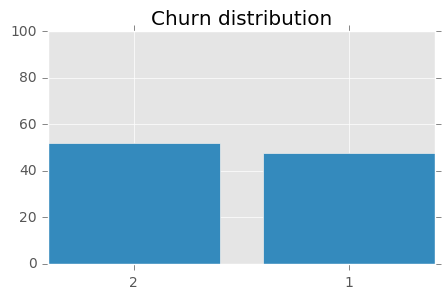

In [282]:
barchart(df_customer, 'churnlabel', title='Churn distribution')

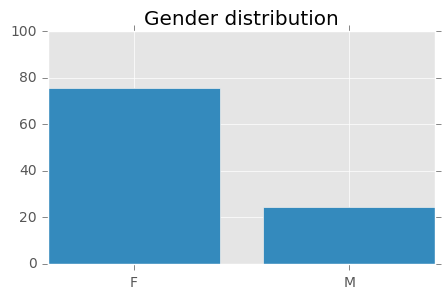

In [283]:
barchart(df_customer, 'gender', title='Gender distribution')

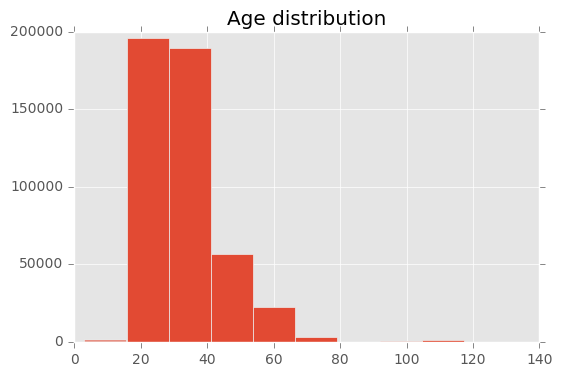

In [284]:
df_customer.Age.hist()
plt.title('Age distribution')

In [285]:
# removing outliers
sum(df_customer.Age>100)


1434

In [286]:
big = df_customer.groupby('shippingCountry').customerId2.count()

In [287]:
df_customer_big = df_customer[df_customer.shippingCountry.isin(big[big>2000].keys())]

In [288]:
df_customer_big = df_customer_big[(df_customer_big.Age>=15) & (df_customer_big.Age<80)]
print('Discarding {:.2f}% of data points'.format((1-len(df_customer_big)/float(len(df_customer)))*100))

Discarding 8.14% of data points


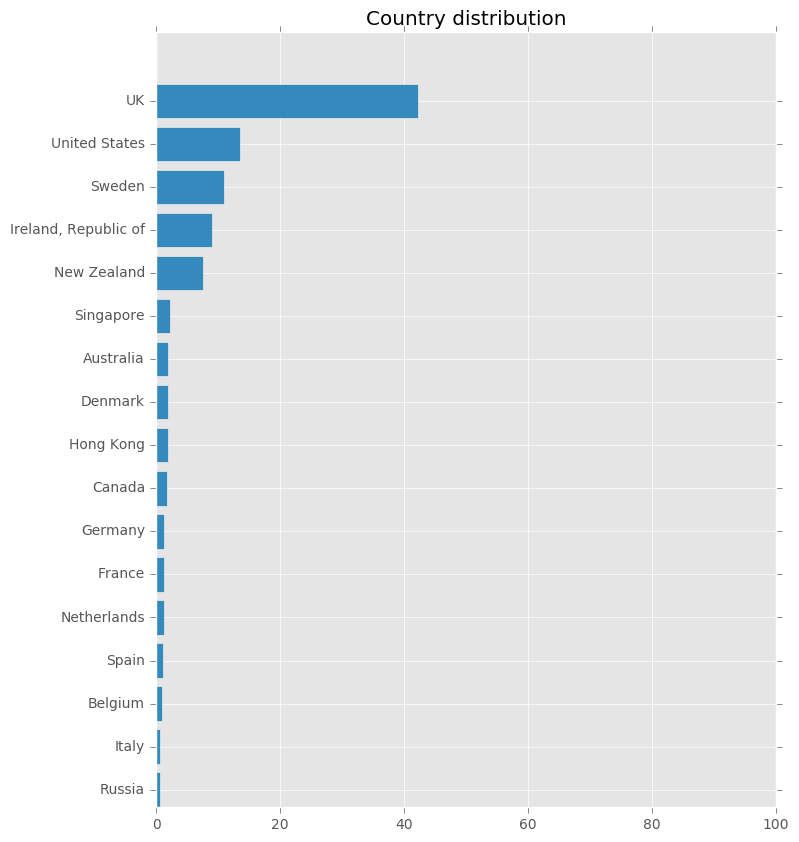

In [289]:
barchart(df_customer_big, 'shippingCountry', title='Country distribution', vertical=True)

In [290]:
idx = np.random.permutation(df_customer_big.shape[0])

# Can we say something with this really basic info?

In [291]:
df_features = df_customer_big.copy()

df_features.loc[df_features.gender=='F', 'gender'] = 0
df_features.loc[df_features.gender=='M', 'gender'] = 1

df_features.drop('yearOfBirth', axis=1, inplace=True)

df_features.drop('dateCreated', axis=1, inplace=True)

#df_features['n_days'] = (datetime.date.today()-df_features['subscription_date']).dt.days

#df_features.n_days.max()

#df_features=df_features[df_features.n_days<10000]

df_features.drop('subscription_date', axis=1, inplace=True)
df_features.drop('customerId2', axis=1, inplace=True)

countrydum = pd.get_dummies(df_features['shippingCountry'])
df_features = pd.concat([df_features, countrydum],axis=1)

df_features.drop('shippingCountry', axis=1, inplace=True)

premierdum = pd.get_dummies(df_features.premier)

df_features = pd.concat([df_features, premierdum],axis=1)

df_features.drop('premier', axis=1, inplace=True)
df_features.fillna(0, inplace=True)

In [292]:
df_features.head()

,churnlabel,gender,Age,Australia,Belgium,Canada,Denmark,France,Germany,Hong Kong,...,Sweden,UK,United States,0,1,2,3,4,5,6
0,2,0,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [293]:
Y = np.array(df_features['churnlabel'])
X = np.array(df_features.drop('churnlabel', axis=1)/df_features.drop('churnlabel', axis=1).max())



ntrain = int(2*len(idx)/3)
xtrain = X[idx[:ntrain], :]
ytrain = Y[idx[:ntrain]]
xtest = X[idx[ntrain:], :]
ytest = Y[idx[ntrain:]]

clf = RandomForestClassifier()

clf.fit(xtrain, ytrain)

pred = clf.predict(xtest)

In [294]:
confusion_matrix(ytest, pred)

array([[50853, 24796],
       [34063, 34248]])

In [298]:
1-sum(np.abs(ytest-pred))/float(len(pred))

0.59114337315921084

In [299]:
precision_score(ytest, pred)

0.59886240520043332

In [300]:
recall_score(ytest, pred)

0.67222303004666284

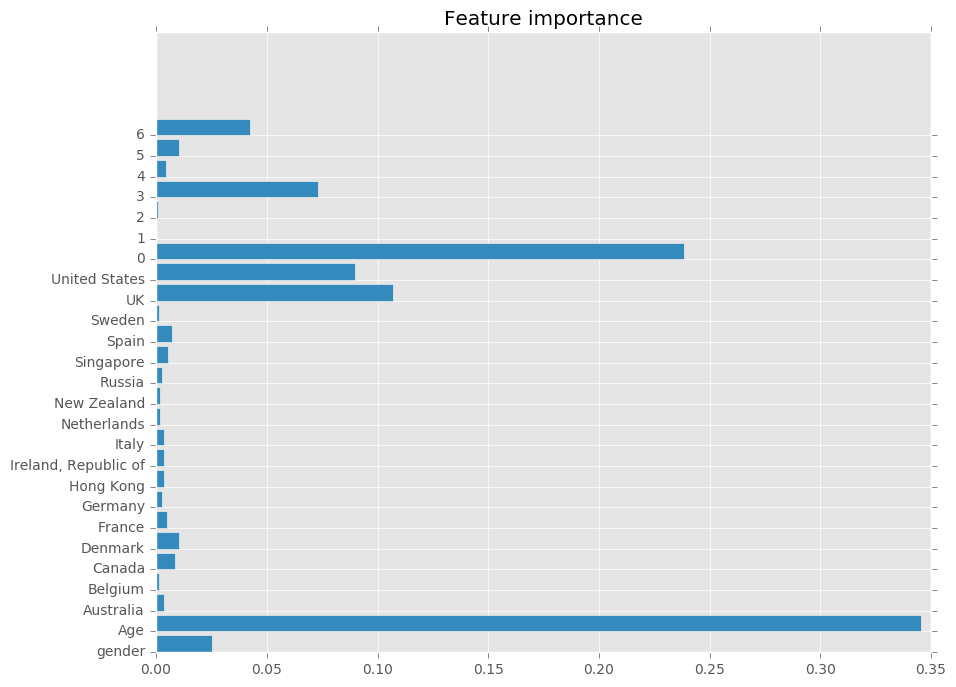

In [111]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
ax.set_yticks(range(len(df_features.columns[1:])))
ax.set_yticklabels(df_features.columns[1:])
ax.set_title('Feature importance')